In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB

import pickle

from mongo_client import mongo_client

In [2]:
db = mongo_client.get_database('historical_events')
collection = db.get_collection('event_descriptions')

In [3]:
stop_words = list(ENGLISH_STOP_WORDS) + [
    'abc', 'ampndash', 'ampamp', 'amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref',
    'http', 'href', 'html', 'htm', 'www', 'com'
]
count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9,
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")
mdocs = [mdoc for mdoc in collection.find()]
docs = [mdoc['description'].split('{{')[0] for mdoc in mdocs]
count_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['could', 'twenty', 'himself', 'it', 'should', 'cant', 'enough', 'together', 'three', 'by', 'further', 'whole', 'alone', 'whatever', 'how', 'after', 'down', 'none', 'give', 'mostly', 'sixty', 'whereafter', 'everywhere', 'afterwards', 'elsewhere', 'next', 'that', 'were', 'anyone', 'un', 'a...amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref', 'http', 'href', 'html', 'htm', 'www', 'com'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [4]:
X = count_vectorizer.transform(docs)
y = [int(mdoc['year'] / 10) * 10 for mdoc in mdocs]
(X[0], y[0])

(<1x36496 sparse matrix of type '<class 'numpy.int64'>'
 	with 8 stored elements in Compressed Sparse Row format>, 1900)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = MultinomialNB()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
clf.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

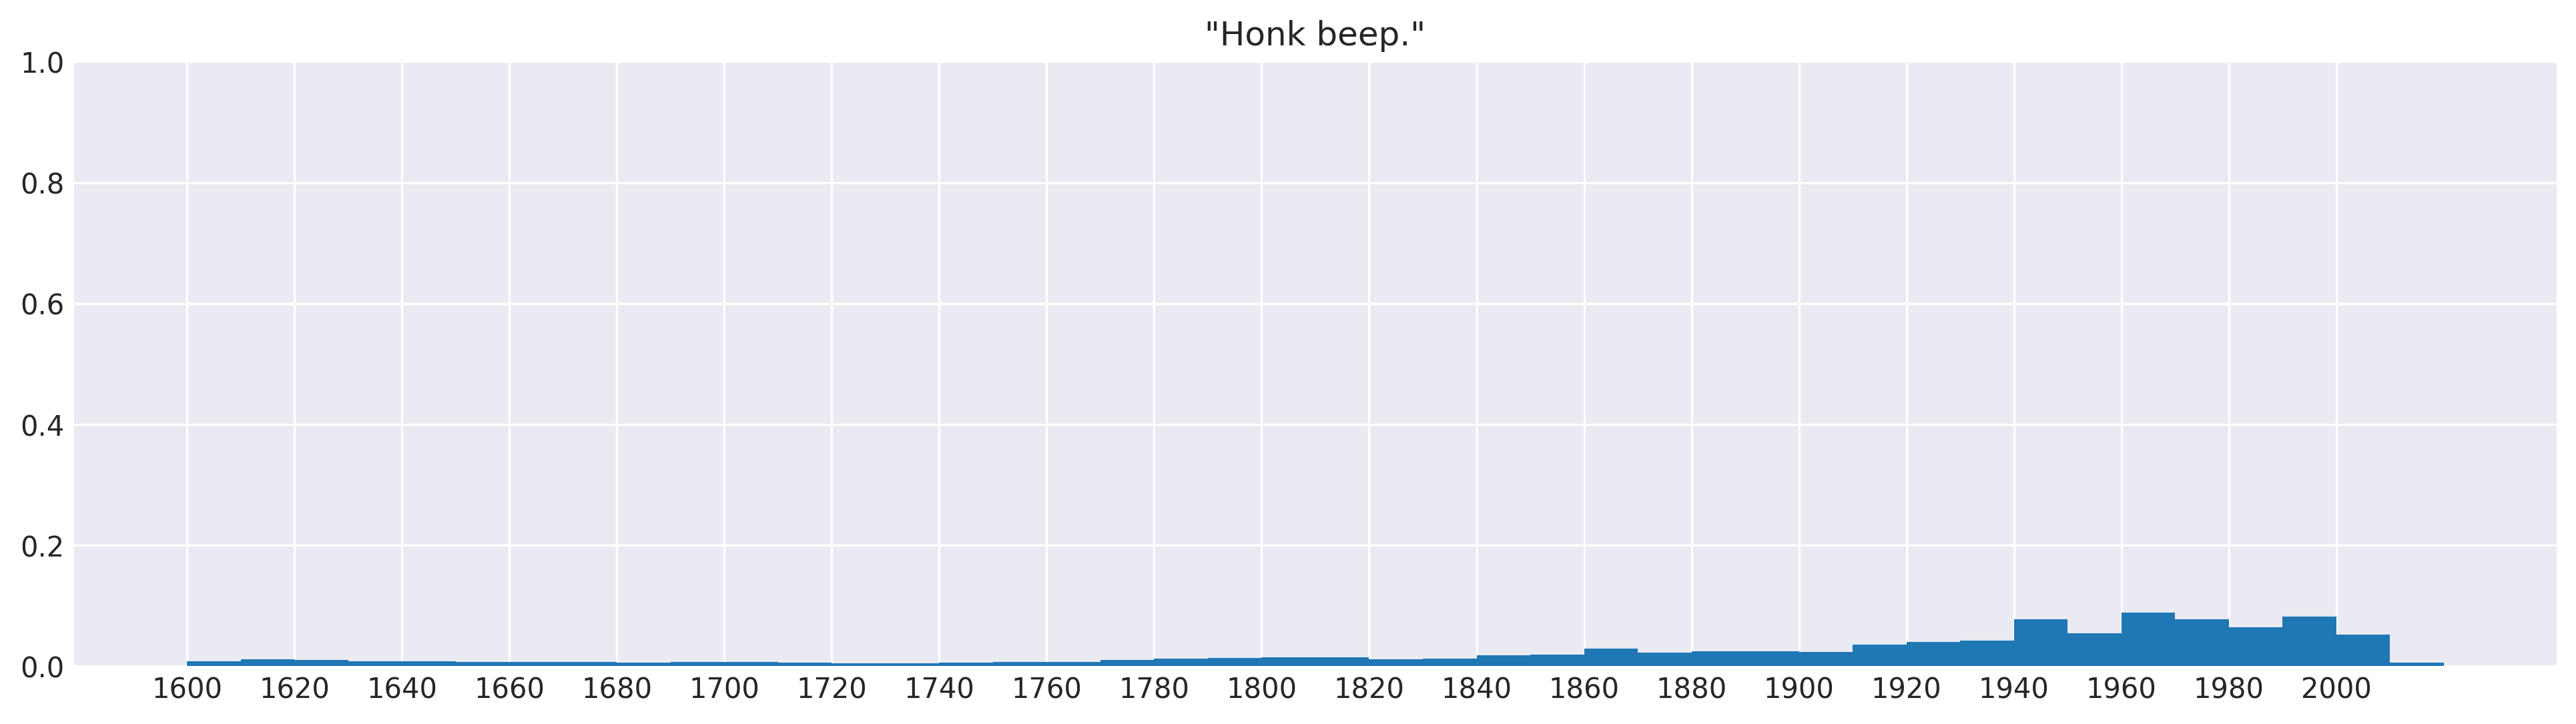

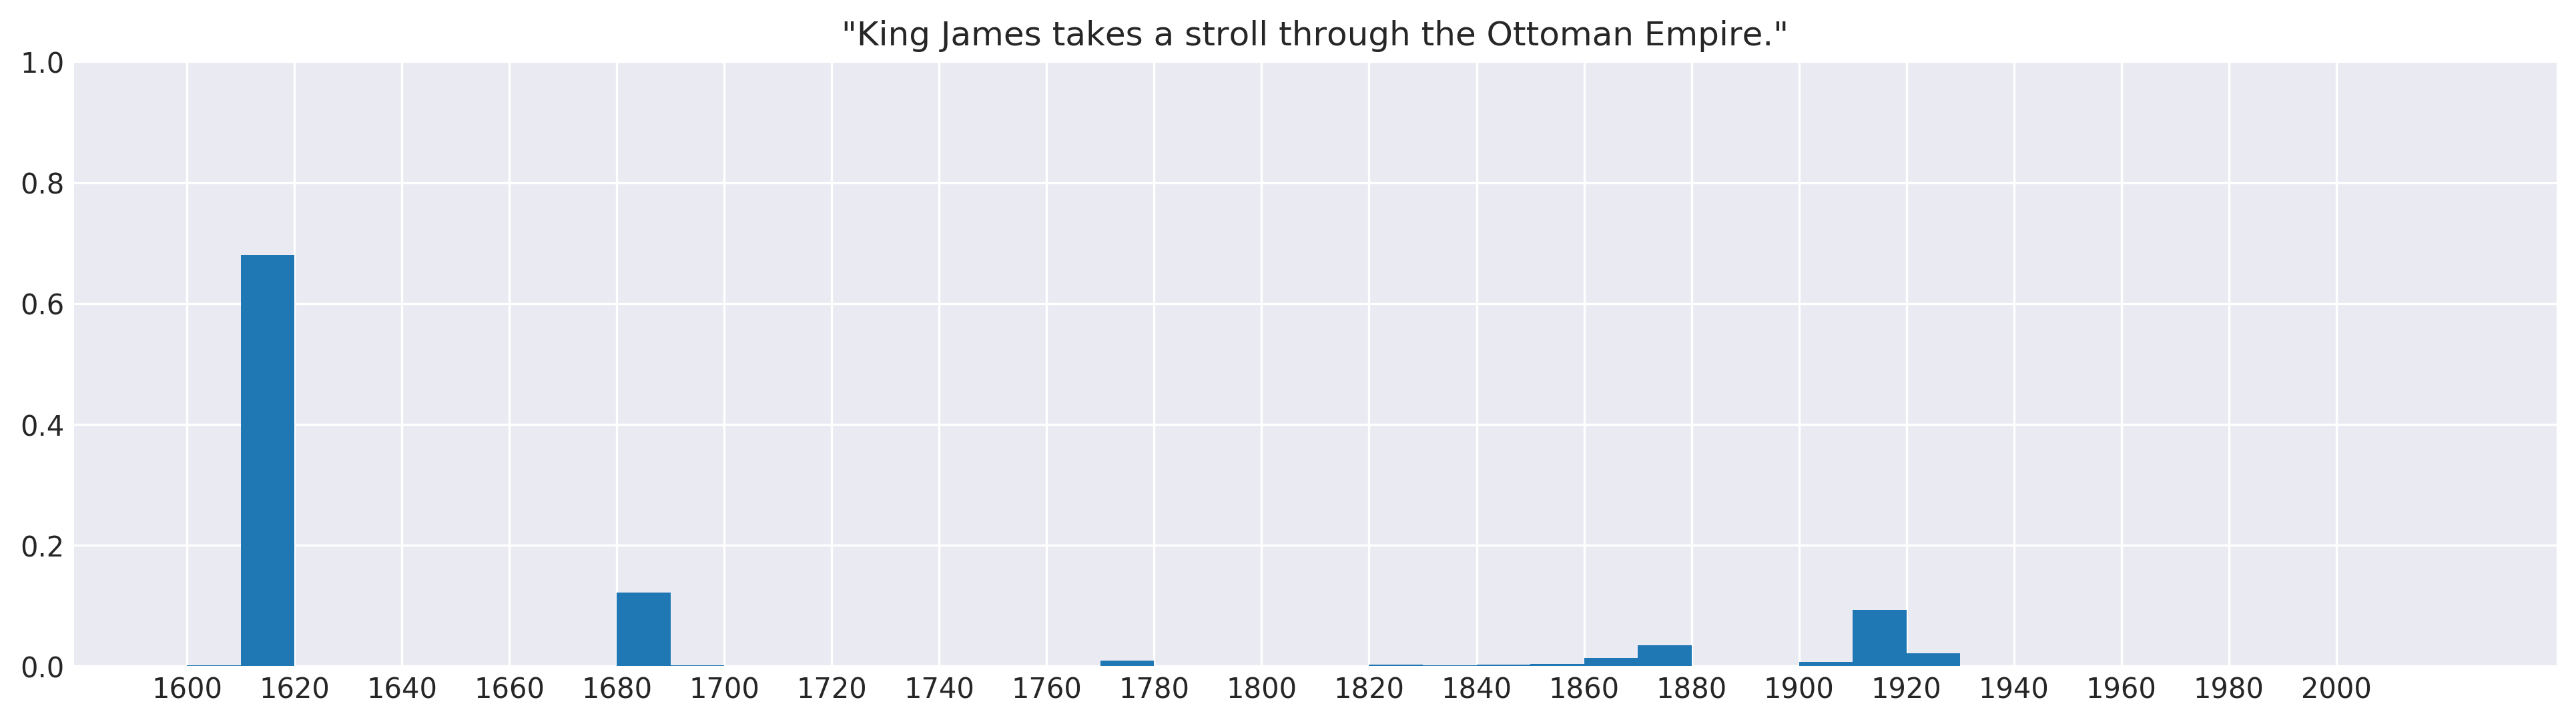

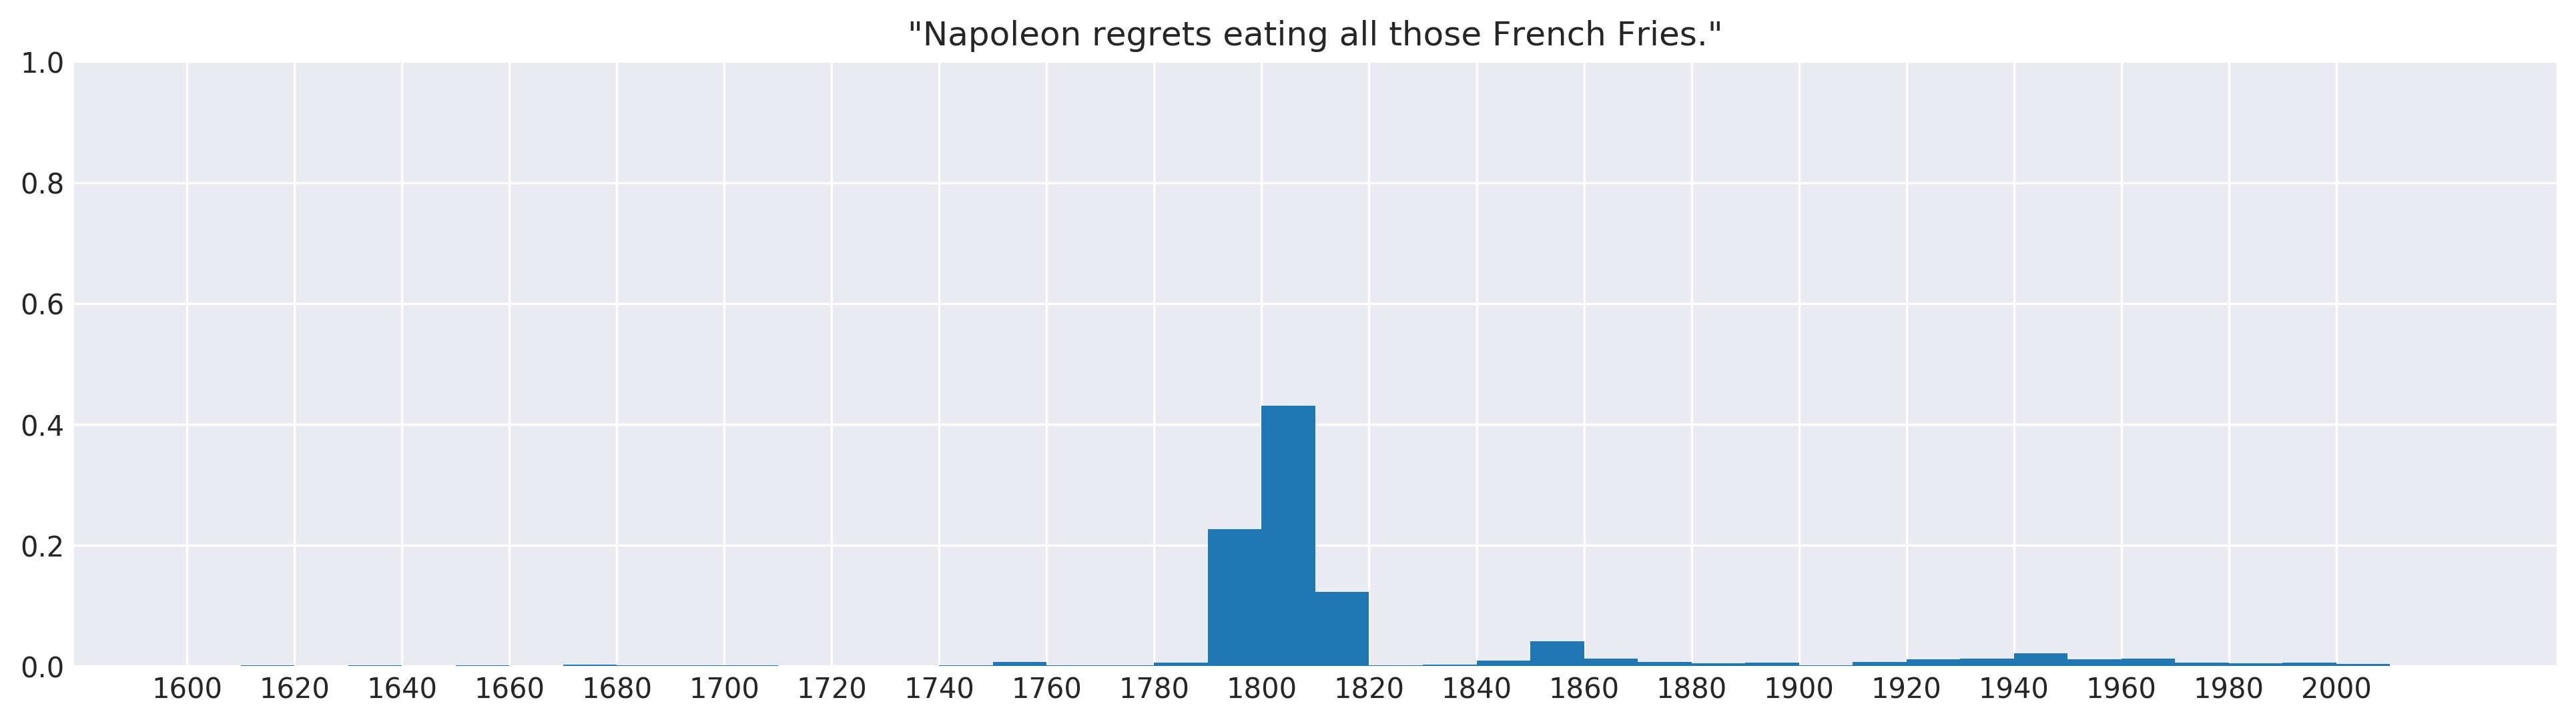

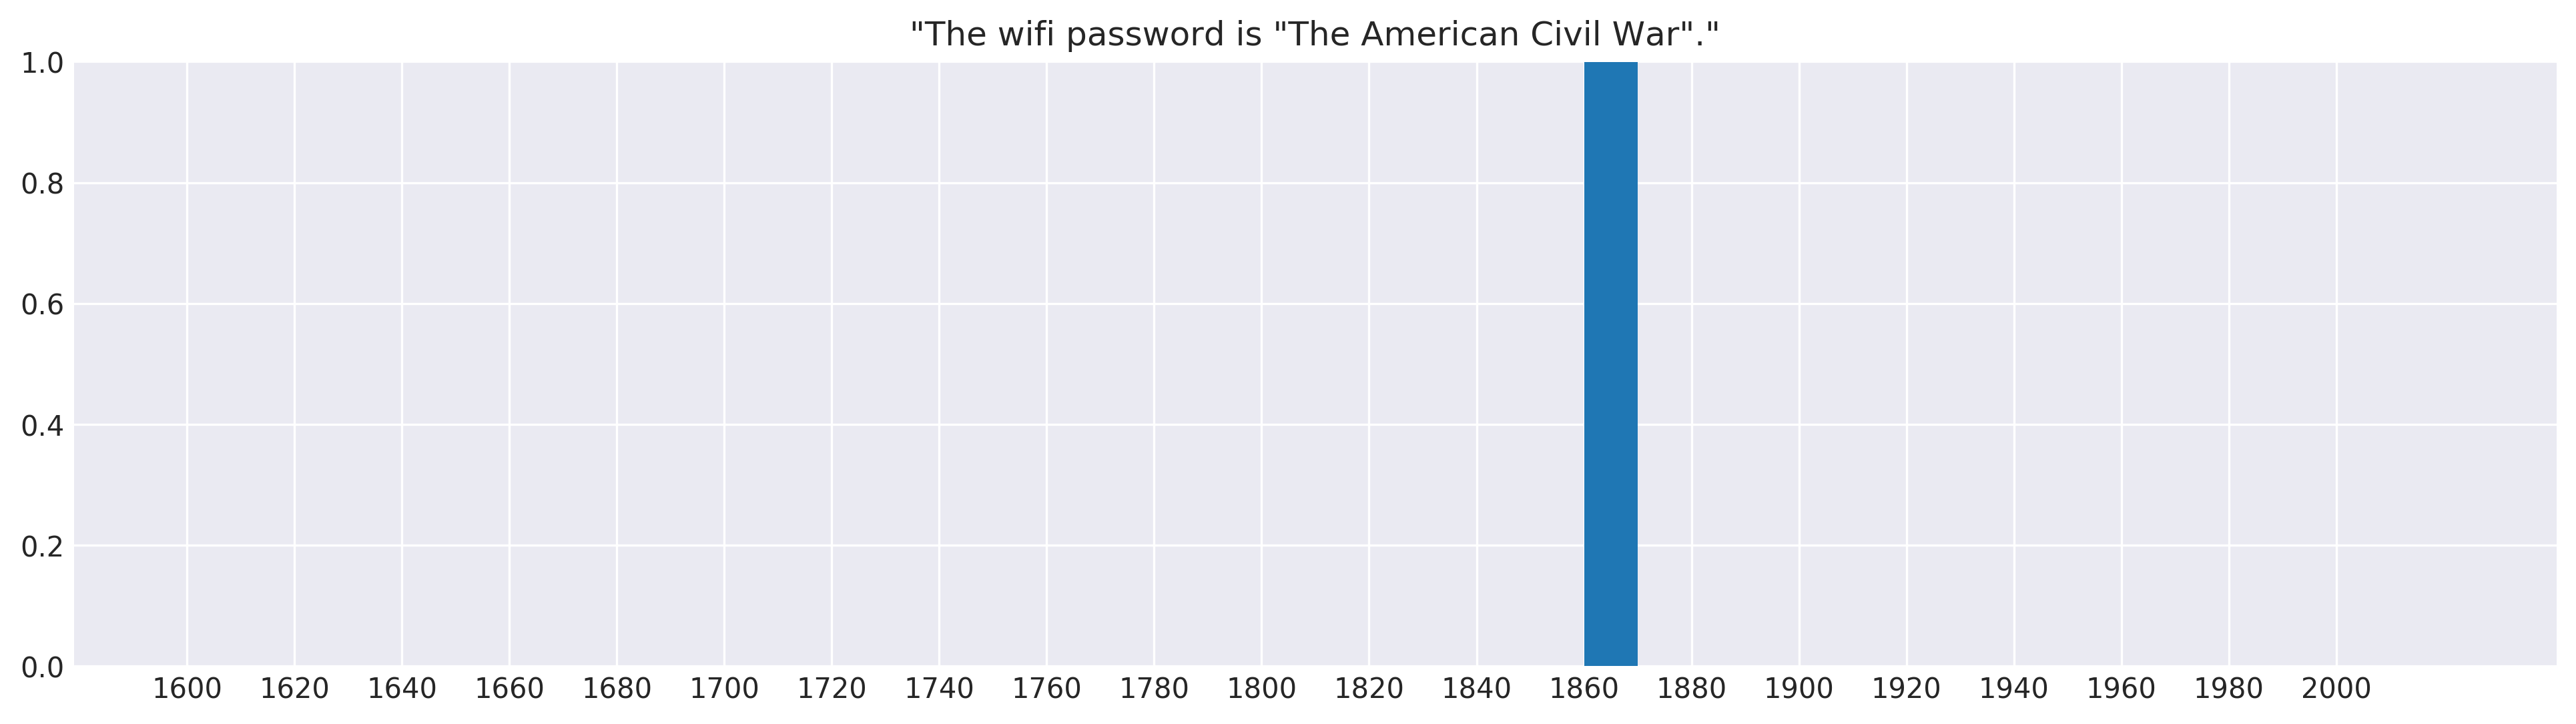

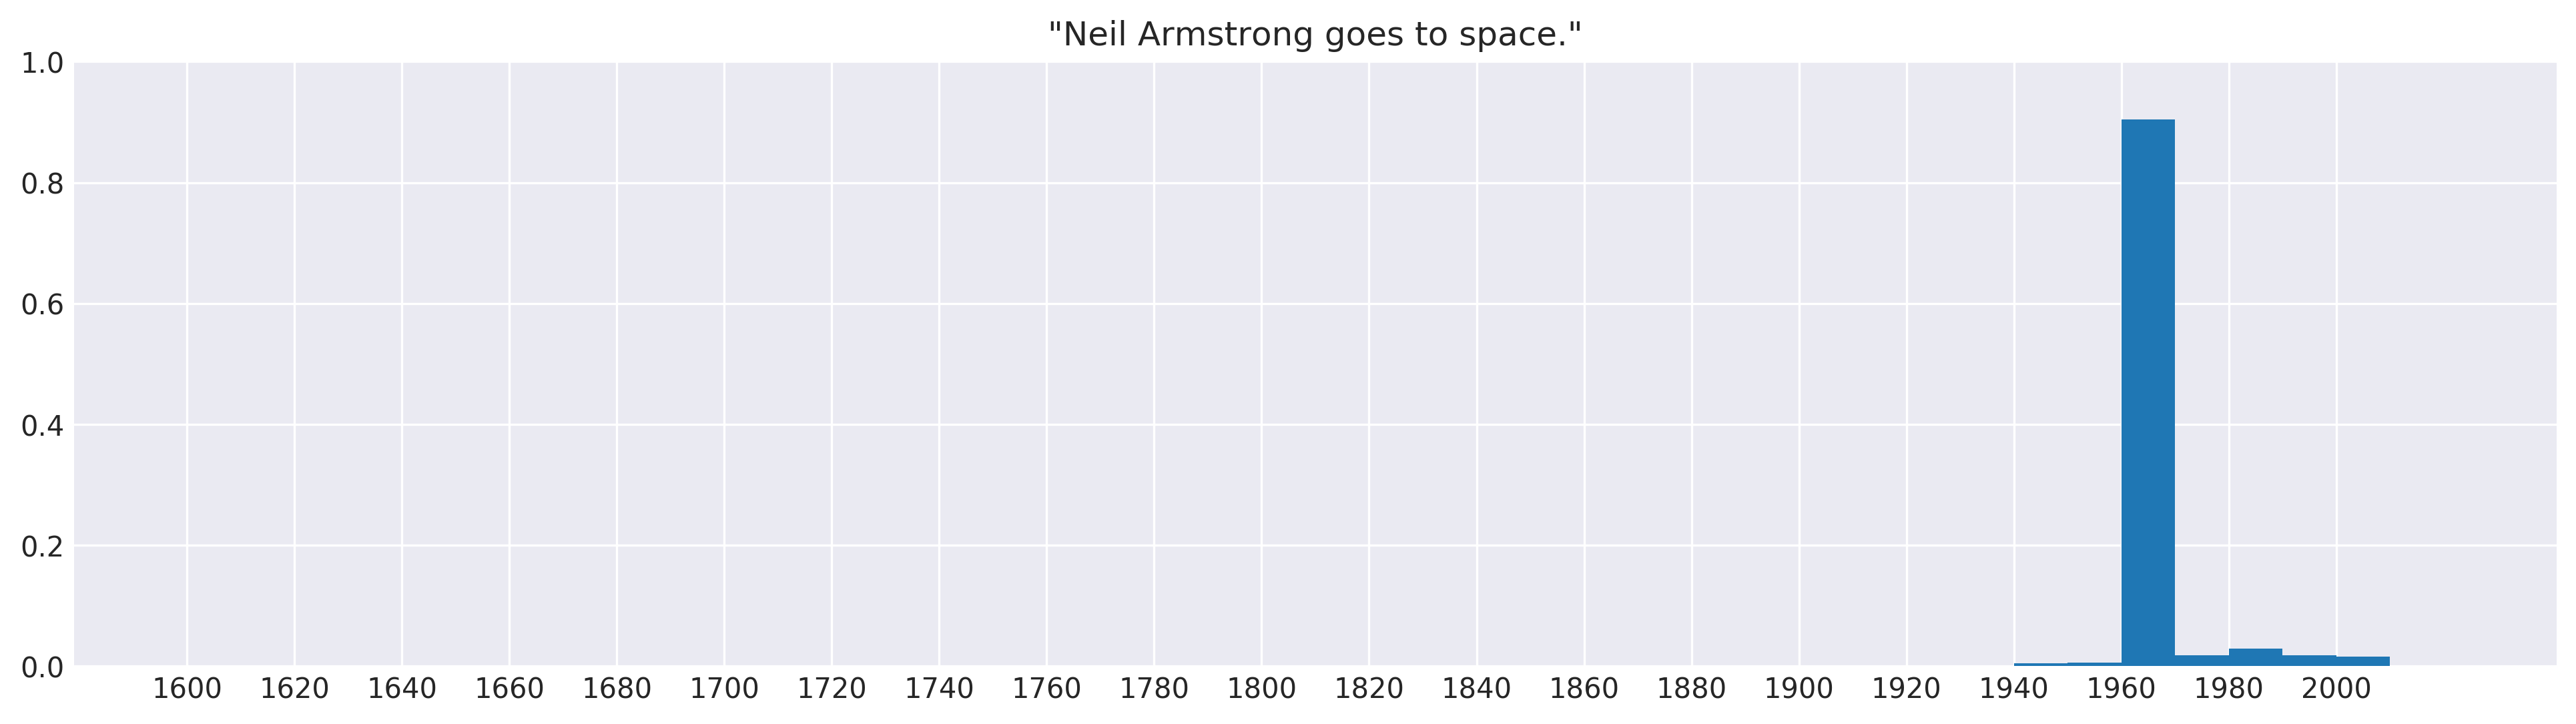

In [6]:
def generate_prediction_graph(sentence):
    pred = clf.predict_proba(count_vectorizer.transform([sentence]))[0]
    plt.figure(figsize=(16, 4), dpi=300)
    plt.title('"{}"'.format(sentence))
    plt.ylim((0, 1))
    decades = range(1600, 1600 + 10 * len(pred), 10)
    plt.xticks([d for d in decades if ((d / 10) + 1) % 2])
    plt.bar(decades, pred, width=10, align='edge');
    
# generate_prediction_graph('Harry Potter wins the Nebraska State Lottery!')
generate_prediction_graph('Honk beep.')
generate_prediction_graph('King James takes a stroll through the Ottoman Empire.')
generate_prediction_graph('Napoleon regrets eating all those French Fries.')
generate_prediction_graph('The wifi password is "The American Civil War".')
generate_prediction_graph('Neil Armstrong goes to space.')

In [7]:
nb_model_components = {
    'count_vectorizer': count_vectorizer,
    'clf': clf
}


with open('nb_model_components.pkl', 'wb') as file:
    pickle.dump(nb_model_components, file)